# Utility

In [2]:
import msgpack
import open3d as o3d
import trimesh
import point_cloud_utils as pcu  # downsampling
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt
import numba
from joblib import Parallel, delayed  # multiprocessing
import multiprocessing
import copy
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from scipy.spatial.transform import Rotation
import tempfile
import gmsh
import meshio
import itertools
import shutil  # file copying
plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

print(f"open3d :{o3d.__version__}")
print(f"trimesh:{trimesh.__version__}")
print(f"numba  :{numba.__version__}")
###########################################################


def normalizeSignedDistance(signed_distance, zero_map_to=0.5):
    """
    Normalize to 0-1
    min-0 map to 0-0.5
    0-max map to 0.5-1
    """
    is_negative = signed_distance <= 0

    normalized_distance = np.zeros_like(signed_distance)
    minimum = signed_distance.min()
    maximum = signed_distance.max()
    normalized_distance[is_negative] = (
        signed_distance[is_negative] - minimum) / np.abs(minimum) * zero_map_to
    normalized_distance[~is_negative] = zero_map_to + \
        signed_distance[~is_negative]/np.abs(maximum)*(1-zero_map_to)
    return normalized_distance


def normalize(v):
    """
    normalize a vector v to [0,1]
    """
    v_min = v.min()
    v_max = v.max()
    v_n = (v - v_min)/(v_max-v_min)  # normalized
    return v_n


# # # https://matplotlib.org/tutorials/colors/colormaps.html
# # cmap = plt.cm.get_cmap('hot')
# sd = np.linspace(-2,2,51)
# mapped = normalizeSignedDistance(sd, zero_map_to=0.0)
# plt.plot(sd,mapped)


coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=60, origin=[0, 0, 0])


def rotate_view(vis):
    ctr = vis.get_view_control()
    ctr.rotate(1.0, 0.0)
    return False

# @numba.jit(["float64[:,:](float64[:,::1], float64,int64)",
#             "float64[:,:](float64[:,:], float64,int64)"],nopython=True)


@numba.jit([
    (numba.types.Array(numba.types.float64, 2, 'C', readonly=True),
     numba.types.float64, numba.types.int64),
    (numba.types.Array(numba.types.float64, 2, 'C', readonly=False), numba.types.float64, numba.types.int64)],
    nopython=True, nogil=True)
def uniformRandomAroundPoints(points, radius, num_per_grid=50):
    """
    sample random points uniformly (along xyz) around an arry of n points (n,3)
    input:
        points: (nx3) numpy array of xyz
        radius: (float scalar) the radius along x,y,z direction to randomly sample the points
        num_per_grid:(float scalar) number of random points to sample per specified point
    """
#     num = points.shape[0]*num_per_grid
#     xyz = np.random.uniform(-radius,radius+np.nextafter(0,1),num*3).reshape((num,3))
#     xyz = xyz + points.repeat(num_per_grid,axis=0)
    num_grid = points.shape[0]
    xyz = np.empty((num_grid*num_per_grid, 3), dtype=np.float64)
#     for i,point in enumerate(points):
    for i in range(num_grid):
        point = points[i]
        start = num_per_grid*i
        end = start+num_per_grid
        xyz[start:end, 0] = np.random.uniform(
            point[0]-radius, point[0]+radius, num_per_grid)
        xyz[start:end, 1] = np.random.uniform(
            point[1]-radius, point[1]+radius, num_per_grid)
        xyz[start:end, 2] = np.random.uniform(
            point[2]-radius, point[2]+radius, num_per_grid)
    return xyz


# example, compile
_ = uniformRandomAroundPoints(np.zeros((2, 3)), 1.0, num_per_grid=5)
_ = uniformRandomAroundPoints(np.ascontiguousarray(
    np.zeros((2, 3))), 1.0, num_per_grid=5)
########################################################################################
########## geometry #####################################################################


def rotateFromVec(vec, angle):
    vec = np.asarray(vec, dtype=np.float64)
    vec_norm = np.linalg.norm(vec)
    if vec_norm != 1:
        vec = vec/vec_norm
    vec *= angle
    h = np.eye(4)
    h[:3, :3] = Rotation.from_rotvec(vec).as_matrix()
    return h


def translate(vec, h=None):
    if h is None:
        h = np.eye(4)
    h[:3, -1] += vec
    return h


def applyTransform(xyz, t):
    """
    apply transform t to xyz, !!Note that t is transposed!!!
    if transform.shape=(3,3): rotation
    if transform.shape=(4,4): homogegenious transformation (rotation+translation)
    """
    xyz = np.asarray(xyz)
    if t.shape == (3, 3):  # rotation matrix
        return np.dot(xyz, t.T)
    elif t.shape == (4, 4):  # homogeneous matrix
        return np.dot(xyz, t[:-1, :-1].T)+t[:-1, -1]
    else:
        raise AssertionError("dimension error")

open3d :0.12.0
trimesh:3.8.19
numba  :0.52.0


In [22]:
def createGrid(bounds=[[-1, -1, -1], [1, 1, 1]], dr=0.1):
    """
    retrun a grid of points shaped (nx,ny,nz,3) given bounds and discritization radius
    where nx,ny,nz are the number of points in x,y,z direction
    the bounds are updated and also returned
    input:
        bounds: [(x_low,y_low,z_low),(x_high,y_high,z_high)]
        dr: discretization radius of the grid
    output:
        xyz_grid: a grid of points numpy array of (nx,ny,nz,3)
        bounds: updated bounds
    """
    # round to integer, type is still float
    bounds = bounds/dr
    bounds = np.stack((np.floor(bounds[0]), np.ceil(bounds[1])))*dr
#     print("bounds=\n", bounds)
    # number of points in x,y,z direction:(nx,ny,nz)
    nx, ny, nz = np.ceil((bounds[1]-bounds[0])/dr).astype(int)
    x = np.linspace(bounds[0, 0], bounds[0, 0]+(nx-1)*dr, num=nx)
    y = np.linspace(bounds[0, 1], bounds[0, 1]+(ny-1)*dr, num=ny)
    z = np.linspace(bounds[0, 2], bounds[0, 2]+(nz-1)*dr, num=nz)
    # a flattened grid of xyzs of the vertices
    xyz_grid = np.stack(np.meshgrid(x, y, z), axis=-1)
    return xyz_grid, bounds


def getUniqueEdges(edges: np.ndarray):
    """
    return unique edges given a possibly non-unique edges
    input:
        edges:  np.ndarray, left and right vertex indices (nx2) 
    output:
        unique_edges: np.ndarray, unique edges
        edge_counts: np.ndarray, count of unique edges
    """
    edges = np.sort(edges, axis=1)  # sorted
    unique_edges, edge_counts = np.unique(
        edges, axis=0, return_index=False, return_counts=True)
    return unique_edges, edge_counts


def getNeighborCounts(unique_edges: np.ndarray):
    """
    return number of neighboring points connected by unique_edges
    input:
        unique_edges:  np.ndarray, unique edges (non-repeating)
    output:
        neighbor_counts:np.ndarray, number of neighboring points sorted by index
    """
    neighbor_counts = np.zeros(unique_edges.max()+1, dtype=int)
    for k in range(2):
        v_id, v_count = np.unique(unique_edges[:, k], return_counts=True)
        neighbor_counts[v_id] += v_count
    return neighbor_counts


def getEdges(neighbor: np.ndarray, self_id: np.ndarray = None, return_edge_counts: np.ndarray = False):
    """
    return the edges given neighbor
    input:
        neighbor: nxm int np.array, assume n points, 
        self_id: if self_id is none, assume: each point has m-1 neighbors,
            neighbor[k,0] is the index of point k iteself, the neighbor points are assorted by distance
            if self_id is specified, then each point has m neighbors
    returns:
        edges: nx2 int np.array, of the edges
    """
    if self_id is None:
        candidate = neighbor[1:]
        self_id = neighbor[0]
    else:
        candidate = neighbor
    edges = np.empty((candidate.size, 2), dtype=np.int32)
    edges[:, 0] = self_id
    edges[:, 1] = candidate

    unique_edges, edge_counts = getUniqueEdges(edges)
    if return_edge_counts:
        return unique_edges, edge_counts
    else:
        return unique_edges


def getMidpoints(points: np.ndarray, epid: np.ndarray):
    """
    return the xyzs of the midpoints given
    points: (nx3 double np.array)
    epid: endpoints indices (nx2 int np.array)
    """
    return 0.5*(points[epid[:, 0]]+points[epid[:, 1]])


def momentOfInertial(p: np.ndarray, p0, n):
    """
    calculate the moment of inertia of points p rotated about axis with normal n,
    p0 is a point on the axis
    """
    if np.abs(np.linalg.norm(n)-1) > 1e-16:
        n = n/np.linalg.norm(n)  # normallize the axis direction
    p0 = np.asarray(p0)
    d = np.cross(p-p0, n)
    return np.sum(np.linalg.norm(d, ord=2, axis=1)**2)


def trimeshToO3dMesh(mesh):
    """
    convert trimesh mesh object to open3d mesh object
    """
    assert(type(mesh) == trimesh.base.Trimesh)
    mesh_o3d = o3d.geometry.TriangleMesh(
        o3d.utility.Vector3dVector(mesh.vertices),
        o3d.utility.Vector3iVector(mesh.faces))
    mesh_o3d.compute_vertex_normals()
    mesh_o3d.compute_triangle_normals()
#     mesh_o3d.paint_uniform_color((0.8, 0.8, 0.8))
    return mesh_o3d


def o3dShow(geometry, **kwargs):
    # The following code achieves the same effect as:
    # o3d.visualization.draw_geometries([pcd])
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    opt = vis.get_render_option()
    if "background_color" in kwargs:  # (r,g,b)
        opt.background_color = np.asarray(
            kwargs["background_color"], dtype=float)
    if "mesh_show_wireframe" in kwargs:  # bool
        opt.mesh_show_wireframe = kwargs["mesh_show_wireframe"]
    if "point_show_normal" in kwargs:  # bool
        opt.point_show_normal = kwargs["point_show_normal"]
    if "show_coordinate_frame" in kwargs:  # bool
        opt.show_coordinate_frame = kwargs["show_coordinate_frame"]
    try:
        for g in geometry:
            vis.add_geometry(g)
    except TypeError:  # geometry is not iteratble
        vis.add_geometry(geometry)
    vis.run()
    vis.destroy_window()
    
    
###########################################################################
def vmeshSummary(vmesh):
    """
    summerize the volume mesh generated by the gmsh and read from the meshio
    """
    tetra = vmesh.cells_dict["tetra"] # (nx4) np array of tetrahedron
    vertices = vmesh.points
    faces = vmesh.get_cells_type("triangle")
    # edges from tetrahedron
    edges_tetra = tetra[:, list(itertools.combinations(range(4), 2))].reshape((-1, 2))
    edges_face = faces[:, list(itertools.combinations(range(3), 2))].reshape((-1, 2))
    # edges, edge_counts = getUniqueEdges(edges)
    edges_tetra, edges_tetra_counts = getUniqueEdges(edges_tetra)
    edges_face, edges_face_counts = getUniqueEdges(edges_face)
    
#     edges = edges_tetra
    edges = edges_face
    neighbor_counts = getNeighborCounts(edges)
    edge_lengths = np.linalg.norm(vertices[edges[:,0]]-vertices[edges[:,1]],axis=1)

    print(f"# vertices          = {vertices.shape[0]}")
    print(f"# surface triangle  =",faces.shape[0])
    print(f"# tetra             =",tetra.shape[0])
    print(f"# unique tetra edges= {edges_tetra.shape[0]}")
    print(f"# unique face  edges= {edges_face.shape[0]}")
    with np.printoptions(precision=3, suppress=True):
        print("COM                 = ",np.mean(vmesh.points,axis=0))
    print(f"mean edge length    = {edge_lengths.mean():.2f}")
        
    fig,ax = plt.subplots(1,3,figsize=(12,2),dpi=75)
    ax[0].hist(edges_tetra_counts,bins=np.arange(0.5,10), density=True)
    ax[0].set_xticks(np.arange(10))
    ax[0].set_xlabel("edge counts")
    ax[1].hist(edge_lengths, density=True, bins='auto')
    ax[1].set_xlabel("edge length")
    ax[2].hist(neighbor_counts, density=True, bins='auto')
    ax[2].set_xlabel("neighbor counts")
    plt.show()

In [166]:
########## discretization parameters ##############
# radius_poisson = float(10) # radius for the poisson sampling
radius_poisson = float(10) # radius for the poisson sampling
radius_knn = radius_poisson*np.sqrt(3)*1.5
# max_nn = 28 # maximun number of neighbors for a mass point (including self)
max_nn = int(28)
inv_scale_grid = float(2.5/np.sqrt(3))
# inv_scale_grid = 1
radius_grid = radius_poisson/np.sqrt(3)/inv_scale_grid # radius for voxelizing before poisson sampling
# radius_grid = radius_poisson/2.5

num_per_grid = int(32/(inv_scale_grid**3))
print(radius_knn)
print(num_per_grid)
print(radius_grid)

half_joint_overlap = radius_poisson * 3
joint_overlap = half_joint_overlap*2
print(f"joint_overlap:{joint_overlap}")


gmsh_args_3d = [
        ("Mesh.Algorithm", 6), # 2D mesh algorithm (1: MeshAdapt, 2: Automatic, 3: Initial mesh only, 5: Delaunay, 6: Frontal-Delaunay, 7: BAMG, 8: Frontal-Delaunay for Quads, 9: Packing of Parallelograms)
        ("Mesh.Algorithm3D", 10), # 3D mesh algorithm (1: Delaunay, 3: Initial mesh only, 4: Frontal, 7: MMG3D, 9: R-tree, 10: HXT)
        ("Mesh.MeshSizeExtendFromBoundary", 1),
        ("Mesh.MeshSizeFromPoints", 1),
        ("Mesh.MeshSizeFromCurvature", 0),
        ("Mesh.OptimizeNetgen",0), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
        ("Mesh.OptimizeThreshold",0.5), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
        ("Mesh.MeshSizeMin", radius_poisson*1.0),
        ("Mesh.MeshSizeMax", radius_poisson*1.4),
        ("Mesh.VolumeEdges",1), # Display edges of volume mesh
        ("Mesh.VolumeFaces",0), # Display faces of volume mesh
        ("Mesh.SurfaceFaces",1), # Display faces of surface mesh?
        ("Mesh.Smoothing",20), # Number of smoothing steps applied to the final mesh
        ("Mesh.Binary",1), # Write mesh files in binary format (if possible)
        ("General.Verbosity",0), # Level of information printed during processing (0: no information), default:5
        ("General.Terminal",0), # Should information be printed on the terminal (if available)
#         ("Mesh.RandomSeed",0), # Seed of pseudo-random number generator
        ("Mesh.QualitySup",0.5), # Only display elements whose quality measure is smaller than QualitySup
]

def generateMesh(
    in_file_name: str, # should be a step cad file
    out_file_name: str = None,# should end with .msh or .stl(2D only)
    gmsh_args: list = gmsh_args_3d,
    dim:int = 3, #mesh dimension {3:volume, 2: surface mesh}
    gui = False, # display gui at the end
):
    """
    return a volume mesh or suface mesh from CAD model
    Input:
    ------------------
    in_file_name : str
        Location of the file to be imported, file type should be 
        ['.brep', '.stp', '.step', '.igs', '.iges',
        '.bdf', '.msh', '.inp', '.diff', '.mesh']
    out_file_name : str
        Location of the file to be imported, file type should be
        '.msh' for 2D/3D mesh or '.stl' for 2D mesh only
    gmsh_args : (n, 2) list
      List of (parameter, value) pairs to be passed to
      gmsh.option.setNumber
    dim : int mesh dimension: 3 for volume mesh, 2 for surface mesh
    
    output:
    -------------------
    a mesh (meshio.Mesh), and out_file_name
    
    note: 
    modified from: ttps://github.com/mikedh/trimesh/blob/master/trimesh/interfaces/gmsh.py 
    for gmsh_arg, refer to: https://gmsh.info/doc/texinfo/gmsh.html#Mesh-options-list
    mesh algorithm: # https://gmsh.info/doc/texinfo/gmsh.html#Choosing-the-right-unstructured-algorithm
    """
 
    
    gmsh.initialize() # !!must be call for initialization!!
    gmsh.option.setNumber("General.Terminal", 1)
    gmsh.model.add('volume_Mesh_Generation')

    gmsh.open(in_file_name)
    
    # # Angle between two triangles above which an edge is considered as sharp:
    # angle = 30
    # # For complex geometries, patches can be too complex, too elongated or too large
    # # to be parametrized; setting the following option will force the creation of
    # # patches that are amenable to reparametrization:
    # forceParametrizablePatches = False
    # # For open surfaces include the boundary edges in the classification process:
    # includeBoundary = True
    # # Force curves to be split on given angle:
    # curveAngle = 180
    # gmsh.model.mesh.classifySurfaces(angle * np.pi / 180., includeBoundary,
    #                                  forceParametrizablePatches,
    #                                  curveAngle * np.pi / 180.)
    # # Create a geometry for all the discrete curves and surfaces in the mesh, by
    # # computing a parametrization for each one
    # gmsh.model.mesh.createGeometry()
    
    gmsh.model.geo.synchronize()

    for arg in gmsh_args:
        gmsh.option.setNumber(*arg)
    
    gmsh.model.mesh.generate(dim)  # generate 3d terahedra mesh
    
#     gmsh.model.mesh.optimize('Netgen', True,niter=2)
#     gmsh.model.mesh.optimize('', True,niter=10)
#     gmsh.model.mesh.optimize('HighOrder', True,niter=20)
    
    if out_file_name is None: # create a temporary file for the results
        with tempfile.NamedTemporaryFile(suffix='.msh', delete=False) as out_data:
            out_file_name = out_data.name            
    gmsh.write(out_file_name)
    
    if gui:
        gmsh.fltk.run() # display gui
    
    gmsh.finalize()  # !!must be call for ending!!
    return meshio.read(out_file_name),out_file_name

25.980762113533157
10
4.0
joint_overlap:60.0


# vertices          = 509
# surface triangle  = 892
# tetra             = 1592
# unique tetra edges= 2546
# unique face  edges= 1338
COM                 =  [16.243 47.079  0.191]
mean edge length    = 12.40


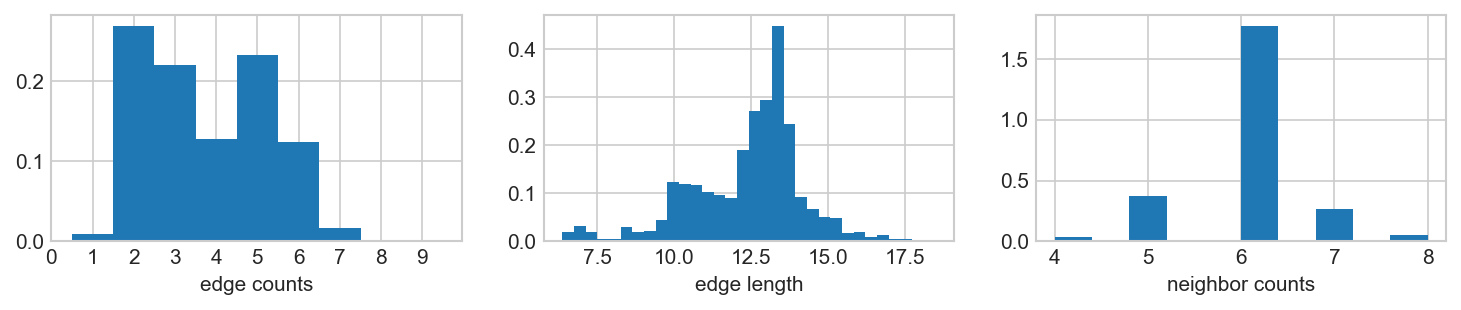

In [167]:
# discretize body
in_file_name: str = "../../mesh/leg_simplified.step"
out_file_name: str = "../../mesh/leg_simplified.msh"
vmesh,_= generateMesh(in_file_name,out_file_name,dim=3,gui=True)
vmeshSummary(vmesh)

In [99]:
# vmesh.cells_dict

# Leg generation

Only need to run once

In [168]:
import cadquery as cq
from math import atan2,pi

leg_d0 = 0.05+2 # length of first segment, 2.2 is the thickness of the coupler
leg_d1 = 120  # length of last segment
leg_r0 = 38   # radius of rotation of mid segment

leg_r1 = 32   # radius of the first segment
leg_r2 = leg_r1   # radius of the end at the second segment
leg_r3 = 24   # radius at the end of the last segment

leg_a0_deg = 90
leg_a0 = leg_a0_deg*pi/180. # mid section rotation angle

taper_angle = atan2(leg_r2-leg_r3,leg_d1) # taper angle [rad] of last section

leg_fillet = 10 # fillet at the end of the leg
leg_innercut_ratio =0.5

def makeLeg(d0 = leg_d0,# length of first segment
            joint_overlap = joint_overlap, #overlap of the joint
            d1 = leg_d1,# length of last segment
            r0 = leg_r0,# radius of rotation of mid segment
            r1 = leg_r1,# radius of the first segment
            taper = taper_angle,# taper angle [rad] of last section
            r_fillet = leg_fillet,# fillet at last section
            innercut_ratio = leg_innercut_ratio
            ):
    path = cq.Workplane("XY").center(0, 0)\
        .line(d0,0).radiusArc((r0+leg_d0,r0),-r0)
    result = cq.Workplane("YZ").circle(r1).sweep(path) # first+mid section
    result = result.faces("<X").circle(r1).extrude(-joint_overlap) # joint overlap section
    result = result.faces(">Y").workplane(centerOption="CenterOfMass").tag("midplane")\
        .circle(r1).extrude(d1,taper=taper*180./pi)\
        .faces(">Y").edges().fillet(r_fillet) # last section fillet
    result = result.workplaneFromTagged("midplane")\
        .circle(r1*innercut_ratio).cutBlind(d1+1,taper=taper*180./pi)
    return result

leg = makeLeg()
# show_object(leg)
cq.exporters.export(leg,"../../mesh/leg_simplified.step")
# cq.exporters.export(leg,"../../mesh/leg_simplified.stl")

# Leg discretization

Only need to run once

# vertices          = 514
# surface triangle  = 892
# tetra             = 1614
# unique tetra edges= 2573
# unique face  edges= 1338
COM                 =  [15.995 46.583  0.257]
mean edge length    = 12.40


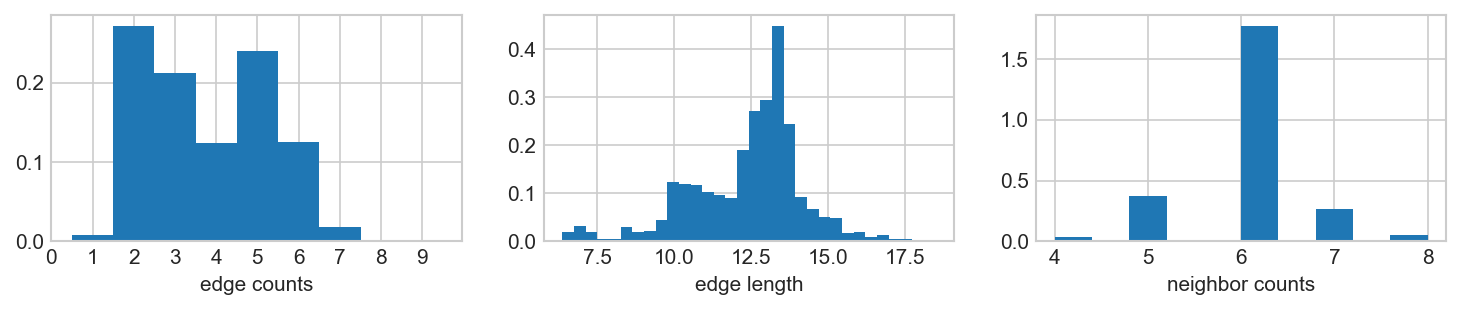

COM at 1st section: [-36.441  -0.034   0.033]


In [169]:
in_file_name: str = "../../mesh/leg_simplified.step"
out_file_name: str = "../../mesh/leg_simplified.msh"

# vmesh,_= generateMesh(in_file_name,out_file_name,dim=3)

# optimze vertices location
n_jobs = int(multiprocessing.cpu_count()*0.2)
total_jobs = int(n_jobs*1)
# print(n_jobs,total_jobs)
result = Parallel(n_jobs=n_jobs)(delayed(generateMesh)(in_file_name,None) for i in range(total_jobs))
mse_list = [np.linalg.norm(np.mean(vmesh.points[vmesh.points[:,0]<=0],axis=0)[1:]) for vmesh,_ in result]
vmesh,best_vmesh_name = result[np.argmin(mse_list)]
shutil.copyfile(best_vmesh_name,out_file_name) # copy the temp file to the out file
vmeshSummary(vmesh)

with np.printoptions(precision=3, suppress=True):
    print("COM at 1st section:",np.mean(vmesh.points[vmesh.points[:,0]<=0],axis=0))    

# Body discretization

Only need to run once

# vertices          = 2294
# surface triangle  = 4092
# tetra             = 7472
# unique tetra edges= 11808
# unique face  edges= 6138
COM                 =  [-0.225 -0.014 -0.156]
mean edge length    = 12.43


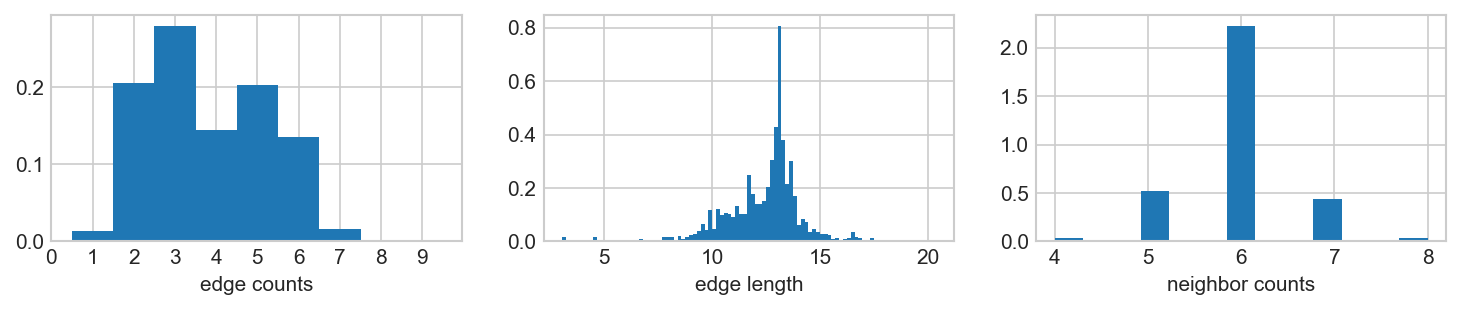

In [170]:
# discretize body
in_file_name: str = "../../mesh/soft_body_simplified.step"
out_file_name: str = "../../mesh/soft_body_simplified.msh"
vmesh,_= generateMesh(in_file_name,out_file_name,dim=3)
# print(vmesh)
vmeshSummary(vmesh)

# Load descritized volume mesh

In [171]:
def voxelizeMesh(mesh,dr=radius_grid):
    """
    input:
        mesh: (trimesh.Trimesh)
    returns:
        bounds: 
    """
    bounds = mesh.bounds
    # convert to integer, type is still float
    bounds = np.vstack(
        (np.floor(mesh.bounds[0]/dr),
         np.ceil(mesh.bounds[1]/dr)))*dr
    xyz_grid, bounds = createGrid(bounds, dr=dr)
    print("bounds=\n", bounds)
    xyz_grid_flat = xyz_grid.reshape((-1, 3))
    
    grid_is_inside_flat = mesh.ray.contains_points(xyz_grid_flat)
    grid_is_inside = grid_is_inside_flat.reshape(xyz_grid.shape[:-1])

    print(f"xyz_grid.shape={xyz_grid.shape}")
    ############################################
    window = np.ones((3, 3, 3))
    grid_is_edge = binary_dilation(
        grid_is_inside, window)*~binary_erosion(grid_is_inside, window)
    # grid_is_edge = binary_dilation(
    #     grid_is_inside)*~binary_erosion(grid_is_inside)
    print(f"{grid_is_edge.sum()}")
    grid_is_deep_inside = grid_is_inside*~grid_is_edge
    # grid points near the edge, sampling around may result in outside points
    xyz_grid_edge = xyz_grid[grid_is_edge]
     # grid points deep inside the body, sampling around garantees inside points
    xyz_grid_inside = xyz_grid[grid_is_deep_inside]
    ##############################
    return bounds,xyz_grid_edge,xyz_grid_inside

def sample_helper(mesh_dict, xyz_grid_edge,xyz_grid_inside,
                  radius_poisson=radius_poisson,radius_grid=radius_grid,num_per_grid=num_per_grid):
    mesh = trimesh.Trimesh(**mesh_dict, use_embree=True)    
    # near-edge points candidate
    xyz_edge_candidate = uniformRandomAroundPoints(xyz_grid_edge,radius_grid,num_per_grid)
    is_edge_candidate = mesh.ray.contains_points(xyz_edge_candidate)
    xyz_edge_candidate = xyz_edge_candidate[is_edge_candidate]
#     print(f"pruning outside points:{xyz_edge_candidate.shape}->{xyz_edge_candidate.shape}")
    # deep-inside points candidate
    xyz_deep_inside_candidate = uniformRandomAroundPoints(xyz_grid_inside,radius_grid,num_per_grid)
    # combined points candidate
    xyz_candidate = np.vstack([xyz_deep_inside_candidate, xyz_edge_candidate])
#     print(f"points near surface:{xyz_edge_candidate.shape}")
#     print(f"points deep inside :{xyz_deep_inside_candidate.shape}")
#     print(f"total points       :{xyz_candidate.shape}")
    xyz, _ = pcu.prune_point_cloud_poisson_disk(v=xyz_candidate, n=np.zeros_like(
    xyz_candidate), radius=radius_poisson, best_choice_sampling=True)
    return xyz # vertices

In [172]:
def descretize(msh_file):
    vmesh = meshio.read(msh_file)

    tetra = vmesh.cells_dict["tetra"] # (nx4) np array of tetrahedron
    vertices = vmesh.points
    faces = vmesh.get_cells_type("triangle")
    # edges from tetrahedron
    edges_tetra = tetra[:, list(itertools.combinations(range(4), 2))].reshape((-1, 2))
    edges_face = faces[:, list(itertools.combinations(range(3), 2))].reshape((-1, 2))

    

    # trimesh mesh
    mesh = trimesh.Trimesh(vertices,faces)
    mesh.visual.face_colors = [255,255,255,255]

    # #     ###############################################################
    # mesh_dict = mesh.to_dict()
    # bounds,xyz_grid_edge,xyz_grid_inside = voxelizeMesh(mesh)
    # vertices = sample_helper(mesh_dict, xyz_grid_edge, xyz_grid_inside)

    pcd_o3d = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(vertices))
    # KDTree for nearest neighbor search
    pcd_tree = o3d.geometry.KDTreeFlann(pcd_o3d)
    neighbors = [np.asarray(pcd_tree.search_hybrid_vector_3d(point, radius_knn,max_nn = max_nn)[1]) for point in vertices]
    edges = np.vstack([getEdges(neighbor[:max_nn]) for neighbor in neighbors])
    edges, edge_counts = getUniqueEdges(edges)
    # trim springs outside the mesh
    mid_points = getMidpoints(vertices,edges)
    is_inside=mesh.ray.contains_points(mid_points)
    edges = edges[is_inside]
    # #     ###############################################################
    edges = np.vstack((edges,edges_tetra))
#     edges = edges_tetra[:]
    
    edges, edge_counts = getUniqueEdges(edges)
    neighbor_counts = getNeighborCounts(edges)
    edge_lengths = np.linalg.norm(vertices[edges[:,0]]-vertices[edges[:,1]],axis=1)

    print(f"# vertices         = {vertices.shape[0]}")
    print(f"# surface triangle =",faces.shape[0])
    print(f"# tetra            =",tetra.shape[0])
    print(f"# unique edges     = {edges.shape[0]}")

    fig,ax = plt.subplots(1,3,figsize=(12,2),dpi=75)
    ax[0].hist(edge_counts,bins=np.arange(0.5,10), density=True)
    ax[0].set_xticks(np.arange(10))
    ax[0].set_xlabel("edge counts")
    ax[1].hist(edge_lengths, density=True, bins='auto')
    ax[1].set_xlabel("edge length")
    ax[2].hist(neighbor_counts, density=True, bins='auto')
    ax[2].set_xlabel("neighbor counts")
    #     plt.tight_layout()
    plt.show()

    signed_distance = trimesh.proximity.signed_distance(mesh,vertices)


    nsd = normalize(signed_distance) # normalized_signed_distance
    print(signed_distance.min(),signed_distance.max())

    pcd_o3d = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(vertices))

    cmap = plt.cm.get_cmap('plasma')
    pcd_o3d.colors = o3d.utility.Vector3dVector(cmap(nsd)[:,:3])


    # # KDTree for nearest neighbor search
    # pcd_tree = o3d.geometry.KDTreeFlann(pcd_o3d)
    # neighbors = [np.asarray(pcd_tree.search_hybrid_vector_3d(point, radius_knn,max_nn = max_nn)[1]) for point in vertices]
    # edges_pcd = np.vstack([getEdges(neighbor[:max_nn]) for neighbor in neighbors])
    # # trim springs outside the mesh
    # mid_points = getMidpoints(vertices,edges_pcd)
    # is_inside=mesh.ray.contains_points(mid_points)
    # edges_pcd = edges_pcd[is_inside]
    # # combine both
    # edges_full = np.vstack((edges,edges_pcd))
    # edges_full = np.sort(edges_full,axis=1) # sorted
    # edges_full = np.unique(edges,axis=0,return_index=False,return_counts=False)

    lsd_o3d = o3d.geometry.LineSet(
        o3d.utility.Vector3dVector(vertices), 
        o3d.utility.Vector2iVector(edges))

    cmap = plt.cm.get_cmap('seismic')

    normalized_edge_lengths = normalize(edge_lengths)
    edges_colors = cmap(normalized_edge_lengths)[:,:3]# drop alpha channel

    #     normalized_edge_counts = normalize(edge_counts)
    #     print(edge_counts.min(),edge_counts.max())
    #     edges_colors = cmap(normalized_edge_counts)[:,:3]# drop alpha channel

    #     lsd_o3d.colors = o3d.utility.Vector3dVector(edges_colors)

    o3dShow([lsd_o3d,pcd_o3d,coord_frame],background_color=(255,255,255),show_coordinate_frame=False,mesh_show_wireframe=True)

    # lsd_o3d = o3d.geometry.TetraMesh(
    #     o3d.utility.Vector3dVector(vmesh.points), 
    #     o3d.utility.Vector4iVector(vmesh.get_cells_type("tetra")))
    # o3d.visualization.draw_geometries([lsd_o3d],mesh_show_wireframe=True)

    #     vsmesh_o3d = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(vertices),o3d.utility.Vector3iVector(faces))
    # o3dShow([vsmesh_o3d,pcd_o3d],background_color=(0,0,0),show_coordinate_frame=False,mesh_show_wireframe=True)

    # display(mesh.show())
    #     display(trimesh.scene.Scene([mesh],).show())
    
    return vmesh,mesh,pcd_o3d,lsd_o3d,nsd

# vmesh_leg,mesh_leg,pcd_leg,lsd_leg,nsd_leg = descretize(msh_file="../../mesh/leg_simplified.msh")

### load descritized leg

# vertices         = 514
# surface triangle = 892
# tetra            = 1614
# unique edges     = 5287


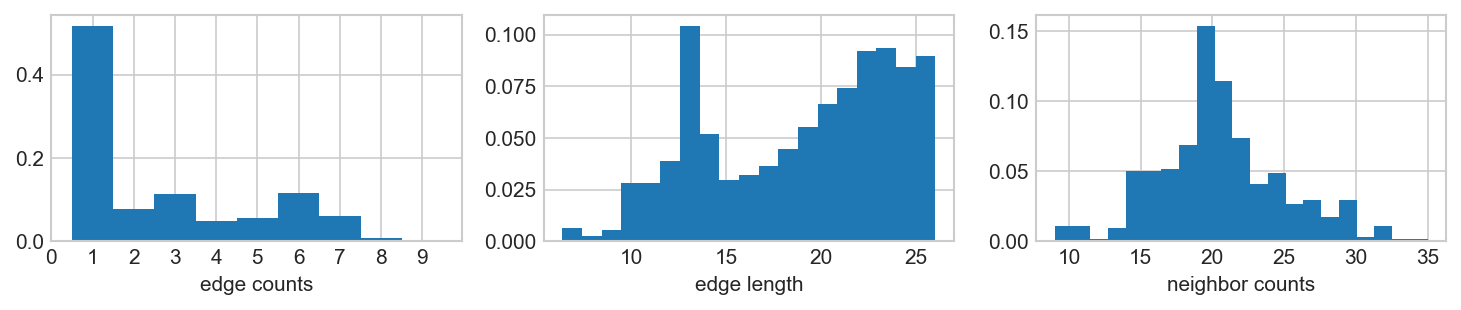

0.0 28.210344676957607


In [173]:
# %load_ext line_profiler
# %lprun -f descretize vmesh_leg,mesh_leg,pcd_leg,lsd_leg,nsd_leg = descretize(msh_file="../../mesh/leg_simplified.msh")

vmesh_leg,mesh_leg,pcd_leg,lsd_leg,nsd_leg = descretize(msh_file="../../mesh/leg_simplified.msh")

### load descritized body

# vertices         = 2294
# surface triangle = 4092
# tetra            = 7472
# unique edges     = 22027


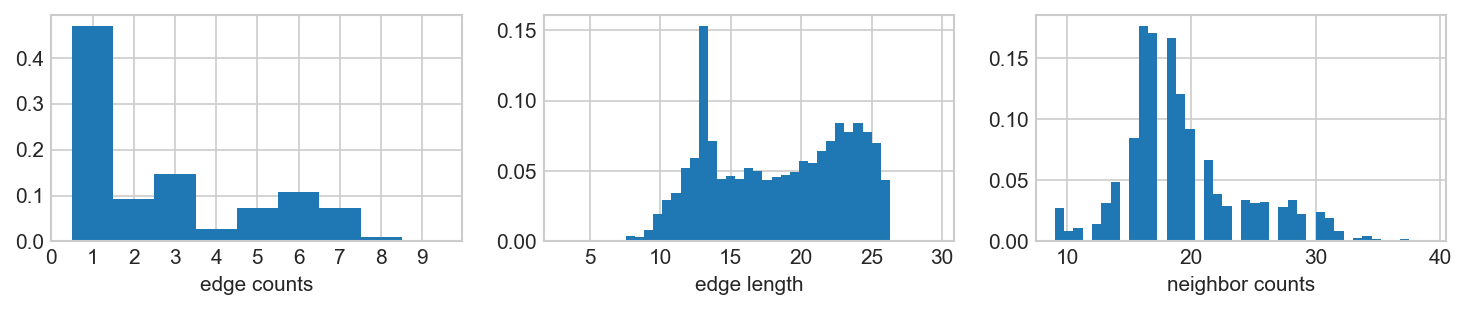

0.0 30.70274003027304


In [174]:
vmesh_body,mesh_body,pcd_body,lsd_body,nsd_body = descretize(msh_file="../../mesh/soft_body_simplified.msh")

# Assemble the parts

In [227]:
############################ defineing joints geometry
dy = 260.0/2
rot_ang = 10.0
cylinder_len = 103

dx_front = 0.0
dx_back = dx_front
########################################################
t_axial = translate((0,0,cylinder_len-half_joint_overlap)) # translate along cylinder
t_zrot = rotateFromVec((0,0,1),np.pi)

t0 = translate((dx_front,0,dy)).dot(rotateFromVec((0, 1, 0),(90-rot_ang)/180.*np.pi).dot(t_axial))# front left
t1 = translate((dx_back,0,-dy)).dot(rotateFromVec((0, 1, 0),(90+rot_ang)/180.*np.pi).dot(t_axial))# back left
t2 = translate((-dx_back,0,-dy)).dot(rotateFromVec((0, 1, 0),(-90-rot_ang)/180.*np.pi).dot(t_zrot).dot(t_axial))# back right
t3 = translate((-dx_front,0,dy)).dot(rotateFromVec((0, 1, 0),(-90+rot_ang)/180.*np.pi).dot(t_zrot).dot(t_axial))# front right
leg_axes_transform = [t0,t1,t2,t3]


joint_radius = radius_poisson*3
# joint_radius = leg_r1
print(f"joint_radius={joint_radius}")
# cylinders for getting the rotation anchor points on the body
cylinders = [trimesh.creation.cylinder(radius=joint_radius, height=joint_overlap, transform=t,sections=60)\
             for t in leg_axes_transform]
##################################################################################################################

joint_radius=30.0


In [228]:
# display(trimesh.scene.Scene(cylinders+[mesh_body]).show())

In [229]:
def ColorizePcdAndLsd(nsd,pcd,lsd,cmap):
    """
    colorize the pcd (o3d pointcloud) and its corresponding lsd (o3d lineset) 
    given nsd (normalized signed distance) and cmap (plt colormap)
    Input:
        nsd: a normalized signed distance of the pcd, normalized to [0,1]
        pcd: o3d point cloud, representing the mass points
        lsd: o3d lineset, representing the springs
        cmap: plt colormap, ref: https://matplotlib.org/tutorials/colors/colormaps.html
    """
    pcd_color = cmap(nsd)[:,:3] # drop alpha channel
    pcd.colors = o3d.utility.Vector3dVector(pcd_color)
    lines = np.asarray(lsd.lines)
    # the line colors are the average of the two end points colors
    lsd_color =  (pcd_color[lines[:,0]]+pcd_color[lines[:,1]])/2
    lsd.colors = o3d.utility.Vector3dVector(lsd_color)
    return pcd,lsd

def LegAlignTransform(rot_angle):
    """
    first align the rotational axis to z-axis, next rotate about the z axis for rot_angle,
    finally translate along z-axis
    """
    return translate((0,0,half_joint_overlap), # translate along z-axis
                     np.dot(rotateFromVec((0,0,1),rot_angle),# rotate about the z axis for rot_angle
                            rotateFromVec((0,1,0),-np.pi/2))) # align the rotational axis to z-axis

# define zero_leg_anges as the leg angles when all the legs are pointing towards front
zero_leg_angles = np.array([np.pi/2,np.pi/2,np.pi/2,np.pi/2]) 

leg_angles = np.array([np.pi,np.pi,0,0]) # four leg standing
# leg_angles = np.array([np.pi/3,np.pi/3,-np.pi/3,-np.pi/3])

# leg_angles = np.array([-np.pi/2,-np.pi/2,-np.pi/2,-np.pi/2])
# leg_angles = np.array([np.pi/2,np.pi/2,np.pi/2,np.pi/2])
# leg_angles = np.array([0,0,0,0])

initial_leg_angles = leg_angles-zero_leg_angles

# axis for the body
body_transform = np.array([[0,1,0,0],[0,0,1,0],[1,0,0,0],[0,0,0,1]],dtype=np.float64)

# axis for the joint - body
leg_transform = [np.dot(t,LegAlignTransform(angle)) for t,angle in zip(leg_axes_transform,leg_angles)]

# axis for the legs
aligned_leg_axes_transform = [np.dot(t,rotateFromVec((0,0,1),a))  for t,a in zip(leg_axes_transform,initial_leg_angles)]

# coordinate for the body
coord_body = o3d.geometry.TriangleMesh.create_coordinate_frame(size=60, origin=[0, 0, 0]).transform(body_transform) 

# coordinates for the joint - body
coord_joint_left = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=60, origin=[0, 0, 0]).transform(t) for t in leg_axes_transform]

# coordinate for the joint - legs
coord_joint_right = [o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=60, origin=[0, 0, 0]).transform(t) for t in aligned_leg_axes_transform]

legs = [o3d.geometry.PointCloud(pcd_leg).transform(t) for t in leg_transform]
lsd_legs = [o3d.geometry.LineSet(lsd_leg).transform(t) for t in leg_transform]


cmap_str = ("spring","summer","autumn","winter")
for k in range(len(legs)):
    legs[k],lsd_legs[k] = ColorizePcdAndLsd(nsd_leg,legs[k],lsd_legs[k],plt.cm.get_cmap(cmap_str[k]))

In [230]:
# o3d.visualization.draw_geometries([pcd_body,coord_body]+coord_joint_left+coord_joint_right+legs)
# o3d.visualization.draw_geometries([pcd_body,coord_body]+coord_joint_left+legs)

# o3d.visualization.draw_geometries([pcd_body,lsd_body,coord_body]+coord_joint_left+legs+lsd_legs)


# o3d.visualization.draw_geometries([pcd_body,coord_frame]+coord_joint_right+legs)

# o3d.visualization.draw_geometries(coord_joint_left+legs)
# o3d.visualization.draw_geometries([pcd_body]+coord_joint_left)
# o3d.visualization.draw_geometries([pcd_body,lsd_body]+legs+lsd_legs+coord_joint_left)
# o3d.visualization.draw_geometries_with_animation_callback([pcd_body,lsd_body]+legs+lsd_legs,rotate_view)
# o3d.visualization.draw_geometries([pcd_body]+coord_joint_left+legs)

In [231]:
# # axes_all = [axis_body, axis_leg0, axis_leg1, axis_leg2, axis_leg3]
# axes_all = [coord_frame] + coord_joint_left

# pcd list of parts
pcd_parts = [pcd_body]+legs 

# lst list of parts
lsd_parts = [lsd_body]+lsd_legs

# # transform_all = [transform_body, transform_leg0, transform_leg1, transform_leg2, transform_leg3]
# transform_all = [np.eye(4)] + leg_axes_transform

# list of boolean array for the rotation ids of the body, 4 in total
body_rot_ids = [cylinder.ray.contains_points(pcd_body.points) for cylinder in cylinders]

# list of np boolean array indicating if point is part of rotational jonit
# leg_rot_ids = [np.asarray(pcd_leg_d.points)[:,0]<-leg_d0,]*len(legs)

pcd_leg_points = np.asarray(pcd_leg.points)
leg_rot_ids = [
    np.logical_and(pcd_leg_points[:, 0] <= 0,
                   (pcd_leg_points[:, 1]**2 +
                   pcd_leg_points[:, 2]**2) <= (joint_radius)**2
                   )]*len(legs)
# leg_rot_ids = [cylinder.ray.contains_points(np.asarray(leg.points)) for cylinder,leg in zip(cylinders,legs)]


# xyzs of the components [body,leg,leg,leg,leg]
xyz_parts = [np.asarray(pcd.points) for pcd in pcd_parts]

# the edges of the points start and end index for each part of the component
id_xyz_parts_edges = np.cumsum([0]+[len(xyz) for xyz in xyz_parts])
print(f"id_xyz_parts_edges={id_xyz_parts_edges}")

# lines of the components [body,leg,leg,leg,leg]
lines_parts = [np.asanyarray(lsd.lines) for lsd in lsd_parts]

id_lines_parts_edges = np.cumsum([0]+[len(lines) for lines in lines_parts])
print(f"id_lines_parts_edges={id_lines_parts_edges}")


n_parts = len(xyz_parts) # number of components
print(f"n_parts={n_parts}")
n_joints = len(legs)
print(f"n_joints={n_joints}")

# array of index of the componet for a joint
id_joint_components = np.array([[0,1],[0,2],[0,3],[0,4]])

# list of transform for each joint
joint_transforms_body = leg_axes_transform
joint_transforms_leg = aligned_leg_axes_transform

# the actual points (bool array)
joint_tuples = list(zip(body_rot_ids,leg_rot_ids))

rot_anchor_radius = half_joint_overlap+radius_poisson*0.5
# rot_anchor_radius = 20
print(f"rot_anchor_radius={rot_anchor_radius}")

# anchor points for each of the rotational joint
rot_anchors = [applyTransform([[0,0,-rot_anchor_radius],
                               [0,0,rot_anchor_radius]],t) 
               for t in leg_axes_transform]
# print(rot_anchors)

# create pointcloud for anchors
pcd_anchors = o3d.geometry.PointCloud()
pcd_anchors.points = o3d.utility.Vector3dVector(np.vstack(rot_anchors))
pcd_anchors.colors = o3d.utility.Vector3dVector(np.tile((1.,0,0), (len(pcd_anchors.points), 1)))

[sum(ids) for ids in body_rot_ids],[sum(ids) for ids in leg_rot_ids]

id_xyz_parts_edges=[   0 2294 2808 3322 3836 4350]
id_lines_parts_edges=[    0 22027 27314 32601 37888 43175]
n_parts=5
n_joints=4
rot_anchor_radius=35.0


([50, 56, 48, 51], [53, 53, 53, 53])

In [232]:
# pcd_body.paint_uniform_color([0, 1, 0])

# for k in range(4):
#     legs[k].paint_uniform_color([0, 1, 0])
#     np.asarray(legs[k].colors)[leg_rot_ids[k]] = np.array((1,0,0))
#     np.asarray(pcd_body.colors)[body_rot_ids[k]] = np.array((0,0,1))

# o3d.visualization.draw_geometries(legs+[pcd_body],point_show_normal=False)

In [205]:
# o3d.visualization.draw_geometries([pcd_body],point_show_normal=False)

In [36]:
# axis_size=5
# axis_origin_tri = trimesh.creation.axis(axis_size*2)
# # front left, back left, front right, back right
# axes = [trimesh.creation.axis(axis_size,transform=t) for t in leg_axes_transform]
# body_trimesh.visual.face_colors=(102, 102, 102, 255)
# pcd_body_trimesh = trimesh.points.PointCloud(np.asarray(pcd_body.points))
# pcd_body_trimesh.visual.vertex_colors = (0, 102, 102, 255)

# legs_trimesh = [trimesh.points.PointCloud(np.asarray(leg.points)) for leg in legs]
# for leg_trimesh in legs_trimesh:
#     leg_trimesh.visual.vertex_colors = np.array((255, 1, 1, 255))
    
# for cylinder in cylinders:
#     cylinder.visual.vertex_colors = np.array((255, 1, 1, 255))

# # scene=trimesh.scene.Scene(geometry=axes+[axis_origin_tri,body_trimesh]+cylinders)
# scene=trimesh.scene.Scene(geometry=axes+[axis_origin_tri,pcd_body_trimesh]+cylinders)
# # scene=trimesh.scene.Scene(geometry=axes+[axis_origin_tri]+cylinders+legs_trimesh)
# scene.show()

In [206]:
NUM_POINTS_PER_COORDINATE = 7 # number of points in a coordinate (o,x,y,z,-x,-y,-z)

def GetCoordinateOXYZ(transform):
    coordinate_radius = 16
    o = transform[:3,-1] # origin
    ox = coordinate_radius * transform[:3,0]
    oy = coordinate_radius * transform[:3,1]
    oz = coordinate_radius * transform[:3,2]
    x = o + ox
    y = o + oy
    z = o + oz
    nx = o - ox # negative x
    ny = o - oy # negative y
    nz = o - oz # netative z
    oxyz = np.vstack([o,x,y,z,nx,ny,nz])
    return oxyz

class Coord:# coordinate
    def __init__(s, body_id, transform):
        """
        body_id: body index,e.g. mainbody=0,leg0=1,leg1=2,leg2=3,leg3=4
        transform: 4x4 numpy transform matrix
        """
        s.bodyId = body_id
        s.transform = transform
        s.oxyz = GetCoordinateOXYZ(transform)
        # index offset for the coordinate
        s.id_start = id_xyz_parts_edges[body_id]


coord_list = [
    Coord(0, body_transform),# body axis
    Coord(id_joint_components[0,0],joint_transforms_body[0]), # joint0-body axis
    Coord(id_joint_components[0,1],joint_transforms_leg[0]), # joint0-leg0 axis
    Coord(id_joint_components[1,0],joint_transforms_body[1]), # joint1-body axis
    Coord(id_joint_components[1,1],joint_transforms_leg[1]), # joint1-leg1 axis
    Coord(id_joint_components[2,0],joint_transforms_body[2]), # joint2-body axis
    Coord(id_joint_components[2,1],joint_transforms_leg[2]), # joint2-leg2 axis
    Coord(id_joint_components[3,0],joint_transforms_body[3]), # joint3-body axis
    Coord(id_joint_components[3,1],joint_transforms_leg[3])  # joint3-leg3 axis
]

# oxyzs: list of oxyz from coord_list
oxyzs = [c.oxyz for c in coord_list]

# # pcd of oxyzs
pcd_oxyzs = o3d.geometry.PointCloud()
pcd_oxyzs.points = o3d.utility.Vector3dVector(np.vstack(oxyzs))
pcd_oxyzs.colors = o3d.utility.Vector3dVector(np.tile((1.,0,0), (len(pcd_oxyzs.points), 1)))
# o3d.visualization.draw_geometries([pcd_oxyzs])

In [207]:
# get all colors
pcds = [pcd_body]+legs+[pcd_anchors]+[pcd_oxyzs]
colors_all = np.vstack(list(map(np.asarray,[pcd.colors for pcd in pcds])))

# the acutal points list, arrange as
# [xyz_0,xyz_1,...,xyz_n,]+ [xyz_anchor_0,...,xyz_anchor_m] + [oxyz_0,oxyz_1,..]
xyzs = xyz_parts + rot_anchors + oxyzs

xyz_all = np.vstack(xyzs)

# the count of points in each component of xyzs
points_counts = [len(xyz) for xyz in xyzs]
print(f"points_counts={points_counts}")


# the edges of the points start and end index for each part of the component
# e.g. the idex of xyzs[k] start at id_xyzs_edges[k], and ends at id_xyzs_edges[k+1]
# the rot_anchors [j] start at id_xyzs_edges[n_parts+k], and ends at id_xyzs_edges[n_parts+k+1]
id_xyzs_edges = np.cumsum([0]+[len(xyz) for xyz in xyzs])
print(f"id_xyzs_edges={id_xyzs_edges}")
list(zip(id_xyzs_edges,"body,leg0,leg1,leg2,leg3,anchor0,anchor1,anchor2,anchor3,oxyz_body,\
oxyz_joint0_body,oxyz_joint0_leg0,oxyz_joint1_body,oxyz_joint1_leg1,\
oxyz_joint2_body,oxyz_joint2_leg2,oxyz_joint3_body,oxyz_joint3_leg3,\
the end".split(",")))

points_counts=[2294, 514, 514, 514, 514, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7]
id_xyzs_edges=[   0 2294 2808 3322 3836 4350 4352 4354 4356 4358 4365 4372 4379 4386
 4393 4400 4407 4414 4421]


[(0, 'body'),
 (2294, 'leg0'),
 (2808, 'leg1'),
 (3322, 'leg2'),
 (3836, 'leg3'),
 (4350, 'anchor0'),
 (4352, 'anchor1'),
 (4354, 'anchor2'),
 (4356, 'anchor3'),
 (4358, 'oxyz_body'),
 (4365, 'oxyz_joint0_body'),
 (4372, 'oxyz_joint0_leg0'),
 (4379, 'oxyz_joint1_body'),
 (4386, 'oxyz_joint1_leg1'),
 (4393, 'oxyz_joint2_body'),
 (4400, 'oxyz_joint2_leg2'),
 (4407, 'oxyz_joint3_body'),
 (4414, 'oxyz_joint3_leg3'),
 (4421, 'the end')]

In [208]:
id_xyzs_anchor_start = id_xyzs_edges[n_parts]
print(f"id_xyzs_anchor_start={id_xyzs_anchor_start}")

id_xyzs_oxyz_start = id_xyzs_edges[n_parts+n_joints]
print(f"id_xyzs_oxyz_start={id_xyzs_oxyz_start}")

id_xyzs_joint_oxyz_start = id_xyzs_edges[n_parts+n_joints+1]
print(f"id_xyzs_joint_oxyz_start={id_xyzs_joint_oxyz_start}")

id_xyzs_anchor_start=4350
id_xyzs_oxyz_start=4358
id_xyzs_joint_oxyz_start=4365


In [209]:
def GetNeighborsOXYZ(pcd,oxyz):
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)
    oxyz_neighbors = [np.asarray(pcd_tree.search_knn_vector_3d(
        point,knn=20)[1]) for point in oxyz]
    return oxyz_neighbors
# oxyzs_neighbors = [np.stack(GetNeighborsOXYZ(pcd,oxyz))+id_start 
#                    for pcd,oxyz,id_start in zip(pcd_parts,oxyzs,id_xyzs_edges)]

oxyzs_neighbors = [np.stack(GetNeighborsOXYZ(pcd_parts[c.bodyId],c.oxyz))+c.id_start 
                   for c in coord_list]

In [210]:
# create oxyz_springs
oxyz_self_springs = []
oxyz_anchor_springs = []
for oxyz,oxyz_neighbor,oxyz_id_start in zip(oxyzs,oxyzs_neighbors,id_xyzs_edges[n_parts+n_joints:]):
    oxyz_id = np.array([oxyz_id_start+k for k in range(NUM_POINTS_PER_COORDINATE)]) # 7 points per coordinate: o,x,y,z,-x,-y,-z
    print(oxyz_id)
    oxyz_anchor_springs.append(
        np.vstack([getEdges(neighbor,point_id) for point_id,neighbor in zip(oxyz_id,oxyz_neighbor)]))
    oxyz_self_springs.append(oxyz_id[
        np.array((
    (0,1),#ox
    (0,2),#oy
    (0,3),#oz
    (0,4),#o-x
    (0,5),#o-y
    (0,6),#o-z
    (1,2),#xy
    (1,3),#xz
    (1,4),#x-x
    (1,5),#x-y
    (1,6),#x-z
    (2,3),#yz
    (2,4),#y-x
    (2,5),#y-y
    (2,6),#y-z
    (3,4),#z-x
    (3,5),#z-y
    (3,6),#z-z
    (4,5),#-x-y
    (4,6),#-x-z
    (5,6)#-y-z
    ))])
oxyz_self_springs = np.vstack(oxyz_self_springs)
oxyz_anchor_springs = np.vstack(oxyz_anchor_springs)

[4358 4359 4360 4361 4362 4363 4364]
[4365 4366 4367 4368 4369 4370 4371]
[4372 4373 4374 4375 4376 4377 4378]
[4379 4380 4381 4382 4383 4384 4385]
[4386 4387 4388 4389 4390 4391 4392]
[4393 4394 4395 4396 4397 4398 4399]
[4400 4401 4402 4403 4404 4405 4406]
[4407 4408 4409 4410 4411 4412 4413]
[4414 4415 4416 4417 4418 4419 4420]


In [211]:
oxyz_id

array([4414, 4415, 4416, 4417, 4418, 4419, 4420], dtype=int32)

In [233]:
# # ids of the leg at rotational joint
# # assume body index start at id_xyzs_edges[0]
# # leg[k] index start at id_xyzs_edges[k+1], ends at id_xyzs_edges[k+2]
# joints = []
# for k,(body_rot_id,leg_rot_id) in enumerate(joint_tuples):
#     body_rot_id_actual = np.ravel(np.where(body_rot_id))+id_xyzs_edges[0]
#     leg_rot_id_actual = np.ravel(np.where(leg_rot_id))+id_xyzs_edges[1+k]
#     anchors_id = np.arange(id_xyzs_edges[len(xyz_parts)+k],id_xyzs_edges[len(xyz_parts)+k+1])
#     # (left_ids,right_ids,anchors_id)
#     joints.append([body_rot_id_actual,leg_rot_id_actual,anchors_id])

# joints_list = [[m.tolist() for m in joint] for joint in joints]

In [212]:
def CreateJointLines(id_0, id_1, id_joint):
    """
    return the joint lines(rotation springs) defined by a joint 
    input:
        id_0: m numpy indices of the first points
        id_1: n numpy indices of the second points
        id_joint: 2 indices of the end points of a joint
    """
    return np.vstack([np.column_stack([id_0, [id_joint[0]]*len(id_0)]), # left  (id_0) - axis_0
            np.column_stack([id_1, [id_joint[0]]*len(id_1)]), # left  (id_0) - axis_1
            np.column_stack([id_0, [id_joint[1]]*len(id_0)]), # right (id_1) - axis_0
            np.column_stack([id_1, [id_joint[1]]*len(id_1)])]) # right (id_1) - axis_1

def CreateJointFrictionSpring(id_0, id_1,num_spring_per_mass= 30):
    """
    return the friction springs defined by a joint 
    input:
        id_0: m numpy indices of the first points
        id_1: n numpy indices of the second points
    """
    max_size = int((len(id_0)+len(id_1))*num_spring_per_mass/2)
    frictionSpring = np.vstack([np.column_stack([[id_0_k]*len(id_1),id_1]) for id_0_k in id_0])
    if frictionSpring.shape[0]>max_size:
        frictionSpring = frictionSpring[np.random.choice(frictionSpring.shape[0], max_size, replace=False)]
    return frictionSpring

In [213]:
class Joint:
    def __init__(s, left, right, anchor):
        s.left = np.copy(left)  # indices of the left mass
        s.right = right  # indices of the right mass
        s.anchor = anchor  # indices of the two ends of the center of rotation
        s.rotSpring = CreateJointLines(
            s.left, s.right, s.anchor)  # rotation spring
        s.friSpring = CreateJointFrictionSpring(
            s.left, s.right)  # friction spring
        s.leftCoord = None
        s.righCoord = None

    def __repr__(s):
        s_rotationSpring = np.array2string(
            s.rotSpring, threshold=10, edgeitems=2).replace("\n", ",")
        s_frictionSpring = np.array2string(
            s.friSpring, threshold=10, edgeitems=2).replace("\n", ",")

        return f"{{left({len(s.left)}):  {np.array2string(s.left,threshold=10,edgeitems=5)}\n" +\
               f" right({len(s.right)}): {np.array2string(s.right,threshold=10,edgeitems=5)}\n" +\
            f" anchor(2): {s.anchor}\n" +\
               f" leftCoord: {s.leftCoord}\n" +\
            f" righCoord: {s.righCoord}\n" +\
            f" rotSpring({len(s.rotSpring)}):{s_rotationSpring}\n" +\
            f" friSpring({len(s.friSpring)}):{s_frictionSpring}}}"

    def tolist(s):
        return [s.left.tolist(), s.right.tolist(), s.anchor.tolist(), int(s.leftCoord), int(s.righCoord)]

In [214]:
# ids of the leg at rotational joint
# assume body index start at id_xyzs_edges[0]
# leg[k] index start at id_xyzs_edges[k+1], ends at id_xyzs_edges[k+2]
joints = []
for k,(body_rot_id,leg_rot_id) in enumerate(joint_tuples):
    body_rot_id_actual = np.ravel(np.where(body_rot_id))+id_xyzs_edges[0]
    leg_rot_id_actual = np.ravel(np.where(leg_rot_id))+id_xyzs_edges[1+k]
    anchors_id = np.arange(id_xyzs_edges[len(xyz_parts)+k],id_xyzs_edges[len(xyz_parts)+k+1])
    # (left_ids,right_ids,anchors_id)
    
    joints.append(Joint(body_rot_id_actual,leg_rot_id_actual,anchors_id))

for k in range(n_joints):
    joints[k].leftCoord = id_xyzs_joint_oxyz_start+NUM_POINTS_PER_COORDINATE*2*k
    joints[k].righCoord = id_xyzs_joint_oxyz_start+(NUM_POINTS_PER_COORDINATE*2)*k + NUM_POINTS_PER_COORDINATE
    
joints_list = [joint.tolist() for joint in joints]
joints

[{left(50):  [1356 1357 1359 1360 1363 ... 2154 2156 2163 2164 2173]
  right(53): [2716 2717 2718 2719 2720 ... 2793 2794 2795 2796 2802]
  anchor(2): [4350 4351]
  leftCoord: 4365
  righCoord: 4372
  rotSpring(206):[[1356 4350], [1357 4350], ..., [2796 4351], [2802 4351]]
  friSpring(1545):[[2145 2759], [2116 2765], ..., [2072 2791], [2057 2754]]},
 {left(56):  [ 560  561  562  563  564 ... 2214 2215 2220 2221 2226]
  right(53): [3230 3231 3232 3233 3234 ... 3307 3308 3309 3310 3316]
  anchor(2): [4352 4353]
  leftCoord: 4379
  righCoord: 4386
  rotSpring(218):[[ 560 4352], [ 561 4352], ..., [3310 4353], [3316 4353]]
  friSpring(1635):[[ 562 3287], [2207 3265], ..., [ 583 3273], [2178 3246]]},
 {left(48):  [ 460  463  464  468  470 ... 2272 2273 2274 2275 2277]
  right(53): [3744 3745 3746 3747 3748 ... 3821 3822 3823 3824 3830]
  anchor(2): [4354 4355]
  leftCoord: 4393
  righCoord: 4400
  rotSpring(202):[[ 460 4354], [ 463 4354], ..., [3824 4355], [3830 4355]]
  friSpring(1515):[[ 4

In [215]:
# array of (the index of the axis points of a joint)
id_joint_keypoints = np.vstack([joint.anchor for joint in joints])
print(f"id_joint_keypoints:\n{id_joint_keypoints}")
# [body_lines,leg_lines_0,leg_lines_1,leg_lines_2,leg_lines_3]
lines_component_list = [lines + id_start for lines,
              id_start in zip(lines_parts, id_xyzs_edges)]

lines_joint_rotation = np.vstack([joint.rotSpring for joint in joints])

lines_joint_friction = np.vstack([joint.friSpring for joint in joints])
# list of all the edges of the assembly

lines_all_list = lines_component_list+[id_joint_keypoints,lines_joint_rotation,lines_joint_friction,
                                       oxyz_self_springs,oxyz_anchor_springs]
lines_all = np.vstack(lines_all_list)

id_lines_edges = np.cumsum([0]+[len(lines) for lines in lines_all_list])
print(f"id_lines_edges:{id_lines_edges}")
id_lines_edges[n_parts]

list(zip(id_lines_edges,"body,leg0,leg1,leg2,leg3,anchors,rotsprings,\
fricsprings,oxyz_self_springs,oxyz_anchor_springs,the end".split(',')))

id_joint_keypoints:
[[4350 4351]
 [4352 4353]
 [4354 4355]
 [4356 4357]]
id_lines_edges:[    0 22027 27314 32601 37888 43175 43179 44013 50268 50457 51717]


[(0, 'body'),
 (22027, 'leg0'),
 (27314, 'leg1'),
 (32601, 'leg2'),
 (37888, 'leg3'),
 (43175, 'anchors'),
 (43179, 'rotsprings'),
 (44013, 'fricsprings'),
 (50268, 'oxyz_self_springs'),
 (50457, 'oxyz_anchor_springs'),
 (51717, 'the end')]

In [216]:
# # np.asarray(pcd_body.colors)[np.sum(body_rot_ids,axis = 0,dtype=bool)]=(0,255,0)
# for k in range(4):
#     np.asarray(legs[k].colors)[leg_rot_id] = (0,255,0)
#     np.asarray(pcd_body.colors)[body_rot_ids[k]] = (0,0,255)

In [217]:
pcd_assembly = o3d.geometry.PointCloud()
pcd_assembly.points = o3d.utility.Vector3dVector(xyz_all)
pcd_assembly.colors = o3d.utility.Vector3dVector(colors_all)

lsd_assembly = o3d.geometry.LineSet()
lsd_assembly.points = o3d.utility.Vector3dVector(xyz_all)
# lsd_assembly.lines = o3d.utility.Vector2iVector(lines_all[id_lines_edges[n_parts]:])

lsd_assembly.lines = o3d.utility.Vector2iVector(lines_all)

# lsd_assembly.lines = o3d.utility.Vector2iVector(lines_all[id_lines_edges[6]:id_lines_edges[7]]) #joint rotspring
# lsd_assembly.lines = o3d.utility.Vector2iVector(lines_all[id_lines_edges[7]:id_lines_edges[8]]) #joint friciton spring


# lsd_assembly.lines = o3d.utility.Vector2iVector(oxyz_self_springs)
# lsd_assembly.lines = o3d.utility.Vector2iVector(oxyz_anchor_springs)
# lsd_assembly.lines = o3d.utility.Vector2iVector(np.vstack((oxyz_anchor_springs,oxyz_self_springs)))

lsd_assembly.colors = o3d.utility.Vector3dVector((colors_all[lines_all[:,0]]+colors_all[lines_all[:,1]])/2)
# o3d.visualization.draw_geometries([pcd_assembly,lsd_assembly,coord_frame]+coord_joint_left)

# o3d.visualization.draw_geometries_with_animation_callback([pcd_assembly,lsd_assembly,coord_body]+coord_joint_left,rotate_view)


In [218]:
print("#springs =%i"%(len(lines_all)))
print("#mass =%i"%(len(xyz_all)))

# # KDTree for nearest neighbor search
# pcd_assembly_tree = o3d.geometry.KDTreeFlann(pcd_assembly)

# # o3d.visualization.draw_geometries([pcd_leg_d,coord_frame])

# neighbors = [np.asarray(pcd_assembly_tree.search_radius_vector_3d(point, radius_knn)[1])
#              for point in xyz_all]
# # neighbors = [np.asarray(pcd_assembly_tree.search_hybrid_vector_3d(point, radius_knn,max_nn = 27))[1] for point in xyz_all]

# # check the distance of the springs
# fig, ax = plt.subplots(figsize=(20,2))
# hist,bin_edges,_ =ax.hist(np.linalg.norm(xyz_all[lines_all[:,0]] - xyz_all[lines_all[:,1]],axis=1),bins=200)
# ax.text(bin_edges[0],0,f"{bin_edges[0]:.1f}",ha="center",va="top",fontsize="x-large",color='r')
# ax.text(bin_edges[-1],0,f"{bin_edges[-1]:.1f}",ha="center",va="top",fontsize="x-large",color='r')
# ax.set_xlabel("spring length")
# ax.set_ylabel("count")
# plt.show()

# neighbor_counts = np.array([len(neighbor) for neighbor in neighbors])
# print(f"mean neighbors ={np.mean(neighbor_counts)}")
# fig, ax = plt.subplots(figsize=(20,2))
# hist,bin_edges,patches =ax.hist(neighbor_counts,bins=28,range=(0,28))
# ax.set_xlabel("#neighbors (including self)")
# ax.set_ylabel("count")
# # ax.text(surface_neighbor_threshold,0,f"{surface_neighbor_threshold}",ha="center",va="top",fontsize="x-large",color='r')
# plt.show()



# # average divergence of the neighbors from a point
# average_divergence = np.linalg.norm([xyz_all[n].mean(axis=0)-xyz_all[n[0]] for n in neighbors],axis=1)
# fig, ax = plt.subplots(figsize=(20,2))
# hist,bin_edges,patches =ax.hist(average_divergence,bins=100)
# ax.set_xlabel("mean divergence of neighbors (including self)")
# ax.set_ylabel("count")
# plt.show()

# # is_suface is boolean array to specify wether the point is near the surface, useful for applying contraints
# surface_neighbor_threshold = int(max_nn*0.9)
# is_suface = np.logical_or(average_divergence>0.6*radius_poisson,neighbor_counts<surface_neighbor_threshold)
# is_suface[id_xyzs_edges[n_parts]:]=False # only body parts are considered
# print(f"%surface points = {is_suface.sum()/len(is_suface)*100:.0f}%")

#springs =51717
#mass =4421


In [219]:
is_suface = np.ones(len(xyz_all),dtype=bool)

# is_suface = np.zeros(len(xyz_all),dtype=bool)
# is_suface[id_xyzs_edges[0]:id_xyzs_edges[1]]=is_surface_body
# for k in range(4):
#     is_suface[id_xyzs_edges[1+k]:id_xyzs_edges[2+k]]=is_surface_leg

# colors_all_check = np.copy(colors_all)
# colors_all_check[is_suface]=(1,0.2,0.2)
# colors_all_check[~is_suface]=(0,0,0.1)

# pcd_assembly.colors = o3d.utility.Vector3dVector(colors_all_check)
# lsd_assembly.colors = o3d.utility.Vector3dVector((colors_all_check[lines_all[:,0]]+colors_all_check[lines_all[:,1]])/2)

# o3d.visualization.draw_geometries([pcd_assembly,coord_frame]+coord_joint_left)

# o3d.visualization.draw_geometries([pcd_assembly])

# o3d.visualization.draw_geometries([pcd_assembly,lsd_assembly])

# o3d.visualization.draw_geometries([pcd_assembly,coord_frame]+coord_joint_left)

# o3d.visualization.draw_geometries([pcd_assembly,lsd_assembly,coord_frame]+coord_joint_left)

# export assembly

In [220]:
# transoformed so that z is pointed up
xyz_all_trans = applyTransform(xyz_all,
                               np.array([[0, 1, 0],
                                         [0, 0, 1],
                                         [1, 0, 0]]).T)

# xyz_all_trans = xyz_all.copy() # stand pose

min_bound = xyz_all_trans.min(axis=0)

# transoformed ofset scaled mm->m
xyz_all_trans = (xyz_all_trans + np.array([0, 0, 0-min_bound[-1]+0]))/1000

# rotation about z
# xyz_all_trans =applyTransform(xyz_all_trans, rotateFromVec([0,0,1],-20*np.pi/180))


pcd_assembly = o3d.geometry.PointCloud(
    o3d.utility.Vector3dVector(xyz_all_trans))
pcd_assembly.colors = o3d.utility.Vector3dVector(colors_all)
lsd_assembly = o3d.geometry.LineSet(
    o3d.utility.Vector3dVector(xyz_all_trans),
    o3d.utility.Vector2iVector(lines_all),
)
lsd_assembly.colors = o3d.utility.Vector3dVector(colors_all[lines_all].mean(axis=1))

coord_frame_mm = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.06, origin=[0, 0, 0])
o3d.visualization.draw_geometries([pcd_assembly,lsd_assembly, coord_frame_mm])

data = [
    xyz_all_trans.tolist(),
    lines_all.tolist(),
    is_suface.tolist(),
    id_xyzs_edges.tolist(),
    id_lines_edges.tolist(),
    colors_all.tolist(),
    joints_list
]
print(xyz_all_trans.min(axis=0))
print(xyz_all_trans.max(axis=0))
print(xyz_all_trans.shape)
print(lines_all.shape)


# https://stackoverflow.com/questions/43442194/how-do-i-read-and-write-with-msgpack

# Write msgpack file
with open('../data.msgpack', 'wb') as outfile:
    msgpack.pack(data, outfile)

[-0.18676242 -0.17285726  0.        ]
[0.18676242 0.17285726 0.19133422]
(4421, 3)
(51717, 2)


In [221]:
colors_all[lines_all].mean(axis=1).shape

(51717, 3)

In [222]:
# Read msgpack file
with open('../data.msgpack','rb') as data_file:
    # data_loaded = json.load(data_file)
    data_loaded = msgpack.unpack(data_file)
print(len(data_loaded[1]))

51717


In [58]:
# x = b'\x01\x02'

# dt = np.dtype(np.uint16)
# dt = dt.newbyteorder('>')
# np.frombuffer(x,dtype=dt)

In [ ]:
mesh = trimesh.load("../../mesh/leg_simplified.stl", use_embree=True)
mesh_dict = mesh.to_dict()

bounds,xyz_grid_edge,xyz_grid_inside = voxelizeMesh(mesh)
##############################
# print(mesh.is_watertight)
# # make mesh white- ish
# mesh.visual.face_colors = (255,255,255,255)
# mesh.show()

####################################
n_jobs = int(multiprocessing.cpu_count()*0.2)
total_jobs = n_jobs*2
result = Parallel(n_jobs=n_jobs)(delayed(sample_helper)(
    mesh_dict, xyz_grid_edge, xyz_grid_inside) for k in range(total_jobs))

# find the leg that has the least deviation from the centerline in the first section
mse_list = [np.linalg.norm(np.mean(v[v[:,0]<=0],axis=0)[1:]) for v in result]
vertices = result[np.argmin(mse_list)]

with np.printoptions(precision=3, suppress=True):
    print("COM at 1st section:",np.mean(vertices[vertices[:,0]<=0],axis=0))
    print("COM:",np.mean(vertices,axis=0))
    
    
#########################################
signed_distance = trimesh.proximity.signed_distance(mesh,vertices)
nsd = normalize(signed_distance) # normalized_signed_distance

pcd_o3d = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(vertices))

cmap = plt.cm.get_cmap('plasma')
pcd_o3d.colors = o3d.utility.Vector3dVector(cmap(nsd)[:,:3])

# KDTree for nearest neighbor search
pcd_tree = o3d.geometry.KDTreeFlann(pcd_o3d)
neighbors = [np.asarray(pcd_tree.search_hybrid_vector_3d(point, radius_knn,max_nn = max_nn)[1]) for point in vertices]
edges = np.vstack([GetEdges(neighbor[:max_nn]) for neighbor in neighbors])
# trim springs outside the mesh
mid_points = GetMidpoints(vertices,edges)
is_inside=mesh.ray.contains_points(mid_points)
edges = edges[is_inside]


lsd_o3d = o3d.geometry.LineSet(
    o3d.utility.Vector3dVector(vertices), 
    o3d.utility.Vector2iVector(edges))
    
o3d.visualization.draw_geometries([pcd_o3d,lsd_o3d, coord_frame])